---

<div align=center>

Practical work

# Photometric analysis of Kuiper Belt Objects

Vincent Foriel\
12/08/2022

</div>

---

## Goal

We have at disposal 2 series of observations, one during the nith of the 8 october 2001 and the other during the night of the 9 october 2001. We want to caracterize an asteroid that figure on these observations.

To do so, we will need these tools:

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.visualization import simple_norm
from photutils.centroids import centroid_quadratic
from photutils import CircularAperture, CircularAnnulus, aperture_photometry
from math import log10

Also, this notebook only manage one serie of observation at a time so please select the serie of observation you want to analyse.

In [2]:
verbose = False #@param {type:"boolean"}
plot_detections = False #@param {type:"boolean"}

class Dataset:
    pass

oct8 = Dataset()
oct8.name = "October 8th"
oct8.path = "rsrc/8_Oct/"
oct8.reference_star_pos = np.array((1083, 660))
oct8.first_asteroid_pos = np.array((1150, 1157))
oct8.last_asteroid_pos  = np.array((1172, 1104))

oct9 = Dataset()
oct9.name = "October 9th"
oct9.path = "rsrc/9_Oct/"
oct9.reference_star_pos = np.array((1683, 1089))
oct9.first_asteroid_pos = np.array((1171, 1166))
oct9.last_asteroid_pos  = np.array((1308, 991))

for dataset in [oct8,oct9]:

    dataset.files = []
    for file in os.listdir(dataset.path):

        # Filtering undesired files
        if not file.startswith("td10r"):
            continue

        dataset.files.append(file)

    dataset.nbfiles = len(dataset.files)

if not os.path.isdir("data"):
    os.mkdir("data")

## What is photometric analysis?

> **Answer to question 1**
> 
> Photometric analysis is a technique used to measure the intensity, the psectrum and the position of a light source or illuminated object in order to characterise them. Photometric analysis is commonly used in many fields, such as astronomy (what we will do here), but also in photography, meteorology, or even artificial vision. It can also be used to determine the optical properties of materials, which is useful for engineering and physics research. In short, photometric analysis is an important technique for measuring and understanding the properties of light and its interaction with objects and materials.
>

## Trajectory determination

### Detection algorithm

In this practical work, we will, in a first time, try to find the asteroid location on both series of observation. To do so, we have to solve 2 problems:
- The shifts between two images (due to the telescope that was not perfectly re-alined)
- The time when these images were taken, which is not perfectly periodic and induce kind of spontaneous acceleration/deceleration in the asteroid trajectory

To solve the first problem, we will focus on one of the brightest star present in all the pictures. Using an algorithm that will detect the highest magnitude on a given image (are here, part of image), we will compute the shift according to the change of position of this star.

To do so, we will use this function:

In [3]:
def find_brightest_object(file, pos, box_size, r=8, r_in=15, r_out=25, plot=False):
    """Find the brightest object in a given box."""
    
    # Loading data
    hdulist = fits.open(file)
    header = hdulist[0].header
    scidata = hdulist[0].data

    # Defining the subimage centered on the target
    D = box_size//2
    data = scidata[pos[1]-D:pos[1]+D,pos[0]-D:pos[0]+D]

    # Computing accurately the position of maximum of brightness
    x1, y1 = centroid_quadratic(data)
    positions = [(x1, y1)]

    # Computing the magnitude of the object
    for _ in range(1): # avoid problem with syntaxic coloration caussed by simple_norm()
        norm = simple_norm(data, 'sqrt', percent=99)
    aperture = CircularAperture(positions, r)
    annulus_aperture = CircularAnnulus(positions, r_in, r_out)
    phot_table = aperture_photometry(data, aperture)
    phot_table['aperture_sum'].info.format = '%.8g' # for consistent table output
    Sum_target_raw=(phot_table['aperture_sum'])
    phot_table = aperture_photometry(data, annulus_aperture)
    phot_table['aperture_sum'].info.format = '%.8g' # for consistent table output
    Sky_background=(phot_table['aperture_sum'])
    Sum_target=Sum_target_raw-Sky_background/(r_out*r_out-r_in*r_in)*(r*r)
    mag = -2.5*log10(Sum_target)
    
    # Computing the magnitude of the object with the exposure time
    r_mag = mag + 25 + 2.5 * log10(header['EXPTIME'])

    if plot:
        plt.imshow(data, norm=norm, origin='lower')
        
        aperture.plot(color='white', lw=2)
        annulus_aperture.plot(color='white', lw=2)

        plt.title(file)
        plt.show()

    return np.array([x1+pos[0]-box_size//2, y1+pos[1]-box_size//2]), mag, r_mag

### Reference points

> **Answer to question 1**
> 
> By looking at the two series of observations, we can see on each one that there is a bright star located (approximatively on the first image) at:
> - 8 October observations: `X=1083`, `Y=660`
> - 9 October observations: `X=1683`, `Y=1089`
>
> We can also observe the asteroid we will consider, located at:
> - 8 October observations:
>   - On first image: `X=1150`, `Y=1157`
>   - On last image: `X=1172`, `Y=1104`
> - 9 October observations:
>   - On first image: `X=1171`, `Y=1166`
>   - On last image: `X=1308`, `Y=991`

### MJD and shifts

Now we can open all the files, get the modified julian date and compute the shifts between the first image and the others.

In [4]:
if verbose:
    print("Image shifts:")

for dataset in [oct8,oct9]:

    dataset.positions = []
    dataset.shifts = []
    dataset.mjds = []

    for file in dataset.files:
        path = os.path.join(dataset.path, file)
        
        # Getting the time of observation
        hdulist = fits.open(path)
        dataset.mjds.append(hdulist[0].header['MJD-OBS'])
        print(dataset.mjds[-1])

        # Finding the position of the reference star
        pos, _, _ = find_brightest_object(path, pos = dataset.reference_star_pos, box_size=300, plot=plot_detections)
        dataset.positions.append(pos)

        # Computing the shift of the image
        dataset.shifts.append(np.copy(dataset.positions[-1]))
        dataset.shifts[-1][0] -= dataset.positions[0][0]
        dataset.shifts[-1][1] -= dataset.positions[0][1]

        # Printing the results
        if verbose:
            print(f"    {file}: x={dataset.shifts[-1][0]:.3f}, y={dataset.shifts[-1][1]:.3f}")

    # Converting to numpy arrays to make it easier to work with
    dataset.positions = np.array(dataset.positions)
    dataset.shifts = np.array(dataset.shifts)
    dataset.mjds = np.array(dataset.mjds)

52190.0979167
52190.1048958
52190.1122569
52190.1189468
52190.1262153
52190.1328935
52190.1415046
52190.1481829
52190.1597454
52190.1664236
52190.1743171
52190.1809954
52190.1953009
52190.2022222
52190.2094792
52190.216169
52190.2235532
52190.2302431
52190.2377778
52190.2444676
52190.2606944
52190.2675347
52190.2748032
52190.2814931
52190.2887731
52190.2954514
52190.3034259
52190.3101157
52190.3232639
52190.3303009
52190.3375926
52190.344294
52190.3528472
52191.0812616
52191.0882986
52191.0955671
52191.1022338
52191.1095139
52191.1162153
52191.1234954
52191.130162
52191.1374537
52191.1441319
52191.1514583
52191.1581481
52191.1654167
52191.1720949
52191.1793403
52191.1860301
52191.2035069
52191.2101968
52191.2179977
52191.2246759
52191.2417014
52191.2485069
52191.2558333
52191.2625116
52191.2747222
52191.2815278
52191.2887847
52191.2954861
52191.3027778
52191.3094444
52191.3216204
52191.3284144
52191.3356944
52191.3423843
52191.3496181
52191.356331


### Trajectory

Once we have theses shifts, we can compute the position of the asteroid on each image by deducing it from the position on the first image and the one on the last image. We remove the shift of the last image to have the position of the object if the telescope was perfectly aligned.

Then, we have 2 points that allow to trace a straight line that represent approximatively the expected position of the asteroïd on each image.

In [5]:
for dataset in [oct8,oct9]:
    print(f"{dataset.name} observations")
    print(f"\tFirst position:           x={dataset.first_asteroid_pos[0]}, y={dataset.first_asteroid_pos[1]}")
    print(f"\tLast position:            x={dataset.last_asteroid_pos[0]}, y={dataset.last_asteroid_pos[1]}")

    # Detecting first asteroid position
    path = os.path.join(dataset.path, dataset.files[0])
    dataset.first_asteroid_pos, _, _ =  find_brightest_object(path, pos=dataset.first_asteroid_pos, box_size=20, r=2.5, r_in=5, r_out=10, plot=plot_detections)

    # Detecting last asteroid position
    path = os.path.join(dataset.path, dataset.files[-1])
    dataset.last_asteroid_pos, _, _ =  find_brightest_object(path, pos=dataset.last_asteroid_pos, box_size=20, r=2.5, r_in=5, r_out=10, plot=plot_detections)

    # Applying shift of the last image to correct the last asteroid position
    dataset.last_asteroid_pos[0] -= dataset.shifts[-1][0]
    dataset.last_asteroid_pos[1] -= dataset.shifts[-1][1]

    print(f"\tCorrected first position: x={dataset.first_asteroid_pos[0]:.2f}, y={dataset.first_asteroid_pos[1]:.2f}")
    print(f"\tCorrected last position:  x={dataset.last_asteroid_pos[0]:.2f}, y={dataset.last_asteroid_pos[1]:.2f}")

October 8th observations
	First position:           x=1150, y=1157
	Last position:            x=1172, y=1104
	Corrected first position: x=1149.48, y=1155.76
	Corrected last position:  x=1263.45, y=1107.23
October 9th observations
	First position:           x=1171, y=1166
	Last position:            x=1308, y=991
	Corrected first position: x=1169.98, y=1166.05
	Corrected last position:  x=1290.14, y=1109.79


### Trajectory corrections

In practice, the shifts are big so this straight line is not accurate at all. To correct this, we will use the time of the observations and the images shifts to correct the trajectory.

In [6]:
for dataset in [oct8,oct9]:
    # Computing linspace trajectory
    linspace_X = np.linspace(dataset.first_asteroid_pos[0], dataset.last_asteroid_pos[0], dataset.nbfiles, endpoint=True) # mjds[-1]+1
    linspace_Y = np.linspace(dataset.first_asteroid_pos[1], dataset.last_asteroid_pos[1], dataset.nbfiles, endpoint=True)

    # Computing time correction factors
    i = np.arange(dataset.nbfiles)

    dataset.relative_mjds = dataset.mjds - dataset.mjds[0]
    a = dataset.relative_mjds / dataset.relative_mjds[-1]
    a[0] = 1
    b = i / i[-1]
    b[0] = 1
    correction_factors = a / b

    # Applying time correction on the linspace
    dataset.time_correction_X = linspace_X[0] + ((linspace_X - linspace_X[0]) * correction_factors)
    dataset.time_correction_Y = linspace_Y[0] + ((linspace_Y - linspace_Y[0]) * correction_factors)

    # Applying space correction on the linspace
    dataset.space_correction_X = linspace_X + dataset.shifts[:,0]
    dataset.space_correction_Y = linspace_Y + dataset.shifts[:,1]

    # Computing asteroid position prediction
    dataset.predicted_object_pos = np.empty((dataset.nbfiles, 2))
    dataset.predicted_object_pos[:,0] = dataset.time_correction_X
    dataset.predicted_object_pos[:,1] = dataset.time_correction_Y
    dataset.predicted_object_pos[:,0] += dataset.shifts[:,0]
    dataset.predicted_object_pos[:,1] += dataset.shifts[:,1]

### Object detection

Now, we have a set of very accurate position predictions. We can use them to detect the asteroid on each image. To do so, we will use the same algorithm as before but with a smaller window to detect the asteroid. The resulting position of the light source will then be considered as the real position of the asteroid, wich allow us to compute the error between the predicted position and the real one.

In [7]:
for dataset in [oct8,oct9]:
    if verbose:
        print("Asteroïd location:")

    dataset.real_object_pos = np.empty_like(dataset.predicted_object_pos)
    dataset.object_mag = np.empty(dataset.nbfiles)
    dataset.object_r_mag = np.empty(dataset.nbfiles)

    dataset.error = np.empty_like(dataset.predicted_object_pos)

    for i, file in enumerate(dataset.files):

        path = os.path.join(dataset.path, file)

        # Getting corrected position
        pos, mag, r_mag = find_brightest_object(path, pos=dataset.predicted_object_pos[i].astype(int), box_size=20, r=3, r_in=5, r_out=8, plot=plot_detections)
        dataset.real_object_pos[i] = pos
        dataset.object_mag[i] = mag
        dataset.object_r_mag[i] = r_mag

        # Computing error
        dataset.error[i] = dataset.real_object_pos[i] - dataset.predicted_object_pos[i]

        if verbose:
            print(f"    {file}: x={dataset.real_object_pos[i][0]:.1f}, y={dataset.real_object_pos[i][1]:.1f}      Error: x={dataset.error[i][0]:.1f}, y={dataset.error[i][1]:.1f}")

### Visualisation

Now, we can plot all of these points on a same image. We can see that the asteroid is well detected on each image.

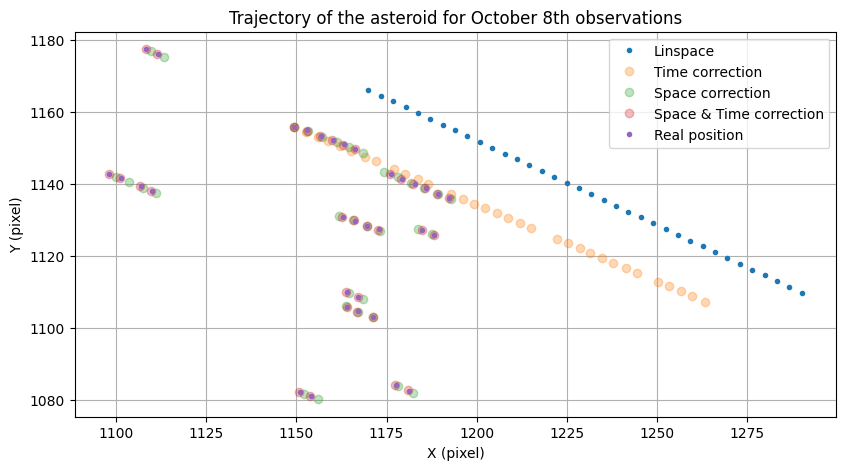

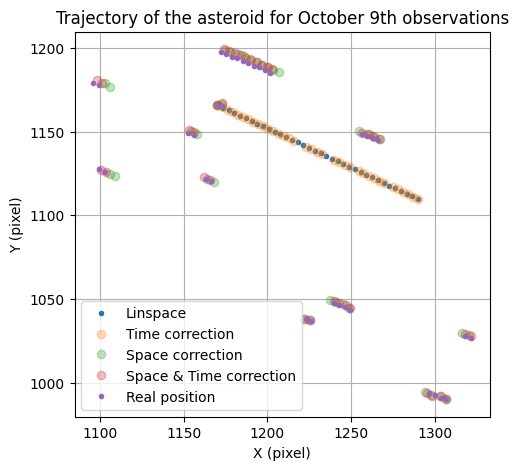

In [8]:
for dataset in [oct8,oct9]:
    fig = plt.figure(figsize=(10,5))
    ax = fig.add_subplot(111)
    ax.plot(linspace_X, linspace_Y, ".", label="Linspace")
    ax.plot(dataset.time_correction_X, dataset.time_correction_Y, "o", label="Time correction", alpha=0.3)
    ax.plot(dataset.space_correction_X, dataset.space_correction_Y, "o", label="Space correction", alpha=0.3)
    ax.plot(dataset.predicted_object_pos[:,0], dataset.predicted_object_pos[:,1], "o", label="Space & Time correction", alpha=0.3)
    ax.plot(dataset.real_object_pos[:,0], dataset.real_object_pos[:,1], ".", label="Real position")
    ax.legend()
    ax.grid()
    ax.set_aspect('equal')
    ax.set_xlabel("X (pixel)")
    ax.set_ylabel("Y (pixel)")
    ax.set_title(f"Trajectory of the asteroid for {dataset.name} observations")
plt.show()

## Magnitude

### Instrumental magnitude

The instrumental magnitude is the magnitude of the asteroid on the image. To get it, we just have to get the maximum value of the pixels representing the object and substract the sky background.

This magnitude is provided by the function `find_brightest_object`.

### R magnitude

The R magnitude is the intrasec magnitude in the R filter, that does not depend on the exposure time. To get it, we will use the formula: $r = mag + 25 + 2.5\log_{10}(t)$.

Where $r$ is the r magnitude with $R = r + 0.25$, $mag$ is the instrumental magnitude, $t$ is the exposure time.

> **Answer to question 2 and 3**
>
> The following code provide an ascii file containing the R magnitude and plot the evolution of the magnitude of the asteroid.

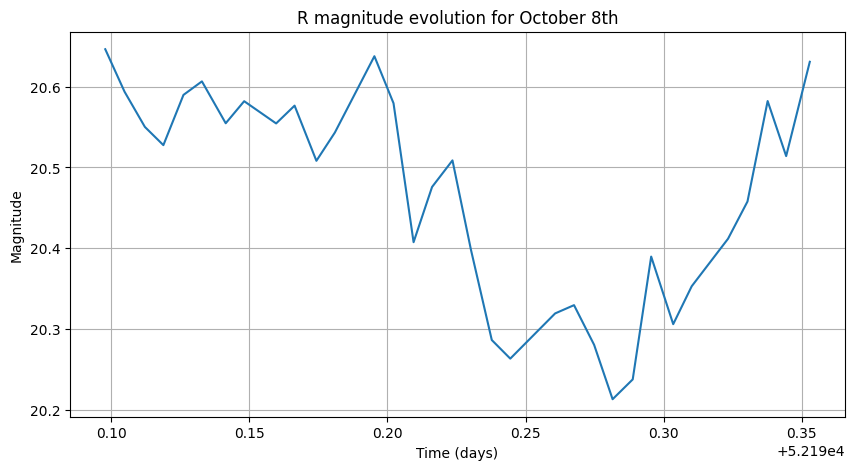

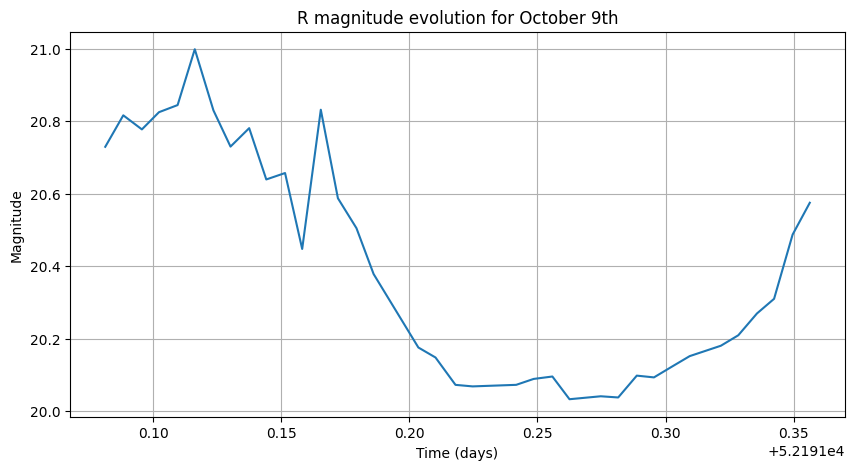

In [9]:
for dataset in [oct8,oct9]:

    # Saving R magnitude
    with open(f"data/{dataset.name.replace(' ', '_')}_R_mag.txt", "w") as f:
        f.write("# MJD\t\tR mag\n")
        for i in range(dataset.nbfiles):
            f.write(f"{dataset.mjds[i]:.3e}\t{dataset.object_r_mag[i] + 0.25:.3e}\n")   

    # Plotting magnitude evolution
    plt.figure(figsize=(10, 5))
    plt.plot(dataset.mjds, dataset.object_r_mag + 0.25)
    plt.xlabel("Time (days)")
    plt.ylabel("Magnitude")
    plt.title(f"R magnitude evolution for {dataset.name}")
    plt.grid()
plt.show()

## Rotation period

### Light curve

We see from the graph above that the magnitude of the asteroid is not constant. We can see a kind of sinusoid variation. To get the period of this variation, we will use a simple non linear fit of a sinusoid function.

[-1.55566206e-01  2.70052420e-01  2.04674583e+01  2.35429962e+02]
[   0.40660833    0.26996157   20.37434014 -174.22971917]


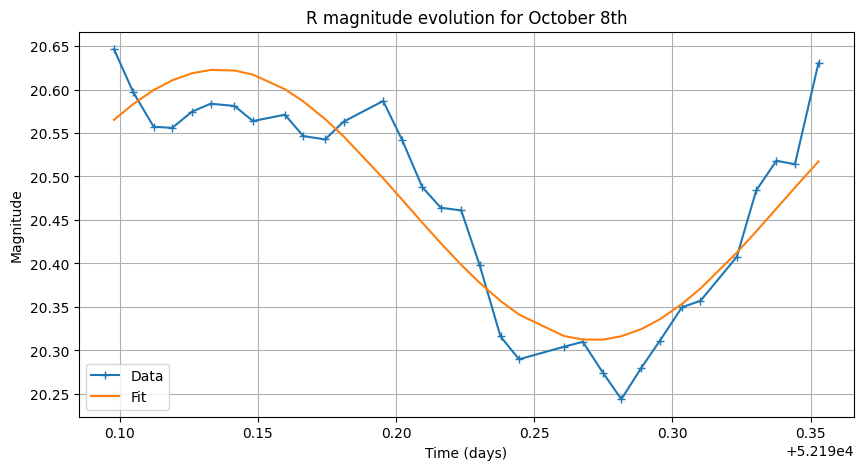

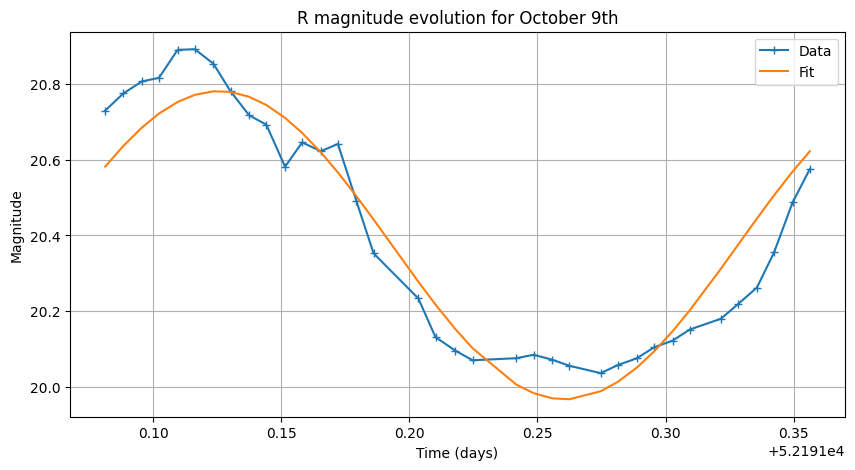

In [10]:
from scipy.optimize import curve_fit, fmin

def f(t, a, T, c, p):
    return a * np.sin(2*np.pi * t/T + p) + c 

for dataset in [oct8,oct9]:

    smooth_radius = 3
    dataset.smoothed_data = np.convolve(dataset.object_r_mag + 0.25, np.ones(smooth_radius)/smooth_radius, mode='same')
    dataset.smoothed_data[:smooth_radius//2] = dataset.object_r_mag[:smooth_radius//2] + 0.25
    dataset.smoothed_data[-smooth_radius//2:] = dataset.object_r_mag[-smooth_radius//2:] + 0.25

    data = dataset.smoothed_data # dataset.object_r_mag + 0.25

    dataset.popt, dataset.pcov = curve_fit(f, dataset.mjds, data, p0=[1, 0.27, 21, 0], maxfev=1000000)

    print(dataset.popt) 

    # def f2(t, T):
    #     return f(t, dataset.popt[0], T, dataset.popt[2], dataset.popt[3])
    
    # dataset.T, dataset.Tcov = curve_fit(f2, dataset.mjds, dataset.object_r_mag + 0.25, p0=0.3, maxfev=1000000)

    # dataset.popt[1] = dataset.T[0]

    plt.figure(figsize=(10, 5))
    plt.plot(dataset.mjds, data, "+-", label="Data")
    plt.plot(dataset.mjds, f(dataset.mjds, *dataset.popt), label="Fit")
    plt.xlabel("Time (days)")
    plt.ylabel("Magnitude")
    plt.title(f"R magnitude evolution for {dataset.name}")
    plt.grid()
    plt.legend()
plt.show()

[3.12645589e-01 3.39648836e-01 2.06084232e+01 1.27600830e+05]


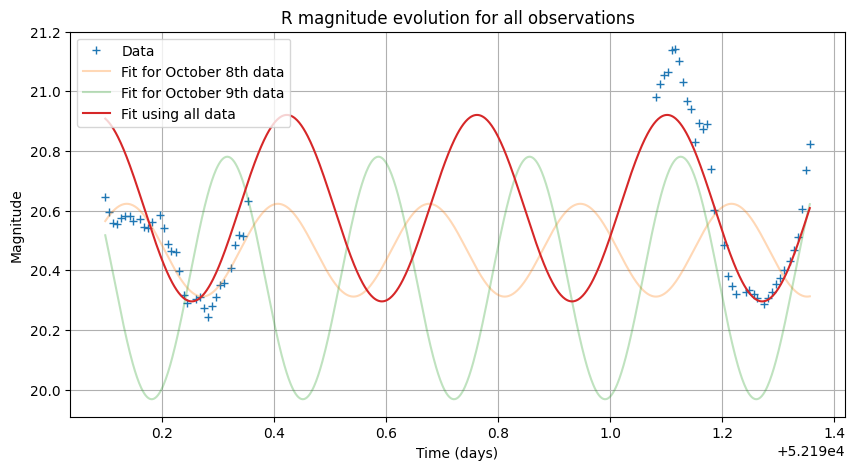

In [11]:
global_mjds = np.concatenate([oct8.mjds, oct9.mjds])
global_mags = np.concatenate([oct8.smoothed_data, oct9.smoothed_data + 0.25])
# global_mags = np.concatenate([oct8.object_r_mag + 0.25, oct9.object_r_mag + 0.25])

t = np.linspace(global_mjds[0], global_mjds[-1], 1000)

popt, pcov = curve_fit(f, global_mjds, global_mags, p0=[1, 0.3, 21, 0], maxfev=10000000)

print(popt)

plt.figure(figsize=(10, 5))
plt.plot(global_mjds, global_mags, "+", label="Data")
for dataset in [oct8,oct9]:
    plt.plot(t, f(t, *dataset.popt), label=f"Fit for {dataset.name} data", alpha=0.3)
plt.plot(t, f(t, *popt), label="Fit using all data")
plt.xlabel("Time (days)")
plt.ylabel("Magnitude")
plt.title(f"R magnitude evolution for all observations")
plt.grid()
plt.legend()
plt.show()

### Rotation period

With this fit, we just got the parameters of the sinusoid function. As we constructed this function using T as a parameter which represent the period, the optimized value for this parameter is then the rotation period !

In [12]:
for dataset in [oct8,oct9]:
    print(f"Estimated period when looking at {dataset.name} observations: {dataset.popt[1]:.3f} days")

Estimated period when looking at October 8th observations: 0.270 days
Estimated period when looking at October 9th observations: 0.270 days


> **Answer to question 4**
>
> The two fits gives us the same period of 0.3 days, but the phase and the amplitude of the light curve are not the same so the two fits doesn't match. This can be due to several reasons:
> - We are not looking at the same asteroid, but both of them have the same period (which is not very likely)
> - There is an error in the MJD of the observations + something caused a global magnitude variation such as a cloud passing by